In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

## 1 K-Means Clustering 

### 1.2 Implementation

In [2]:
p1_data = pd.read_pickle("./hw4_p1.pkl")
p1_data.shape

(3451, 2)

In [3]:
x_vals = p1_data[:,0]
y_vals = p1_data[:,1]

/var/folders/jw/6cygsm496qs9d6kbsmmwmnrc0000gn/T/ipykernel_81130/1740308363.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(p1_data[:, 0], p1_data[:, 1], cmap='viridis', alpha=0.6)


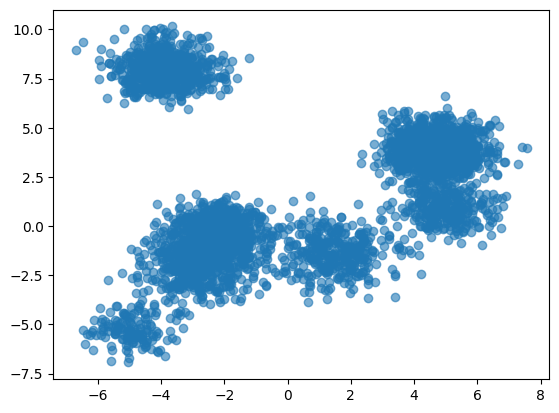

In [5]:
plt.scatter(p1_data[:, 0], p1_data[:, 1], cmap='viridis', alpha=0.6)

In [6]:
def init_clusters(K):
    mins = p1_data.min(axis=0)
    maxs = p1_data.max(axis=0)
    points = np.random.uniform(low=mins, high=maxs, size=(K,2))
    return points

In [7]:
def distance(x, z):
    N, D = x.shape
    K, _ = z.shape
    distances = np.zeros((N, K))  
    
    for i in range(N):           
        for j in range(K):      
            diff = x[i] - z[j] 
            distances[i, j] = np.linalg.norm(diff)  
    return distances

In [8]:
def assignment(dist):
    return np.argmin(dist, axis=1)

In [9]:
def update_centroids(X, labels, centroids):
    num_centroids, _ = centroids.shape
    new_centroids = []
    for k in range(num_centroids):
        points = X[labels == k]
        if len(points) == 0:
            new_centroids.append(X[np.random.randint(len(X))])
        else:
            new_centroids.append(points.mean(axis=0))
    return np.vstack(new_centroids)

In [10]:
def cluster_knn(X, num_clusters):
    tol = 1e-4
    k = init_clusters(num_clusters)
    iter_wss = []
    convergence = False
    while not convergence:
        dists = distance(X, k)
        labels = assignment(dists)
        new_k = update_centroids(X, labels, k) 
        
        if np.allclose(k, new_k, atol=tol):   
            convergence = True
        k = new_k
        iter_wss.append(calc_wss(X, labels, k))
        
    return k, labels,iter_wss 
        

In [11]:
def calc_wss(X, labels, centroids):
    wss = 0.0
    for k in range(centroids.shape[0]):
        points = X[labels == k]
        wss += np.sum((points - centroids[k])**2)
    return wss

In [12]:
k, labels, iter_wss = cluster_knn(p1_data, 2)
iter_wss

[np.float64(70452.81402082296),
 np.float64(59450.92624545978),
 np.float64(57430.30437945025),
 np.float64(57301.704491697004),
 np.float64(57301.704491697004)]

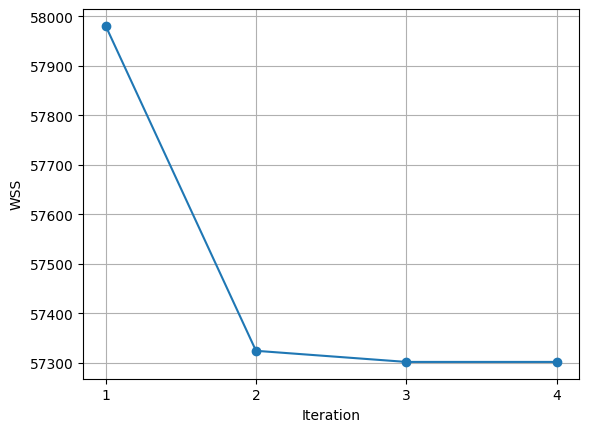

In [18]:
x_values = list(range(1, len(iter_wss) + 1))

plt.plot(x_values, iter_wss, marker='o')
plt.xlabel("Iteration")
plt.ylabel("WSS")
plt.xticks(x_values)
plt.grid(True)
plt.show()

In [15]:
elbow =[]
for i in range(1,10):
    k, labels, _ = cluster_knn(p1_data, i)
    wss = calc_wss(p1_data, labels, k)
    elbow.append(wss)

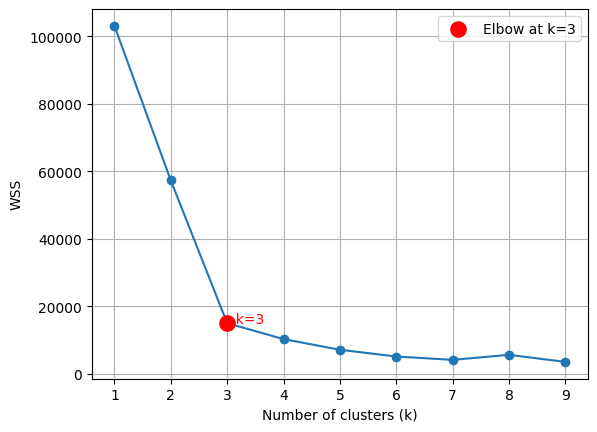

In [16]:
x_values = list(range(1, len(elbow) + 1))

plt.plot(x_values, elbow, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WSS")

k_elbow = 3
wss_elbow = elbow[k_elbow - 1]  

plt.scatter(k_elbow, wss_elbow, color='red', s=120, zorder=3, label=f'Elbow at k={k_elbow}')
plt.text(k_elbow, wss_elbow, f"  k={k_elbow}", color='red')

plt.xticks(x_values)  
plt.legend()
plt.grid(True)
plt.show()

In [19]:
k, labels, _ = cluster_knn(p1_data, 3)

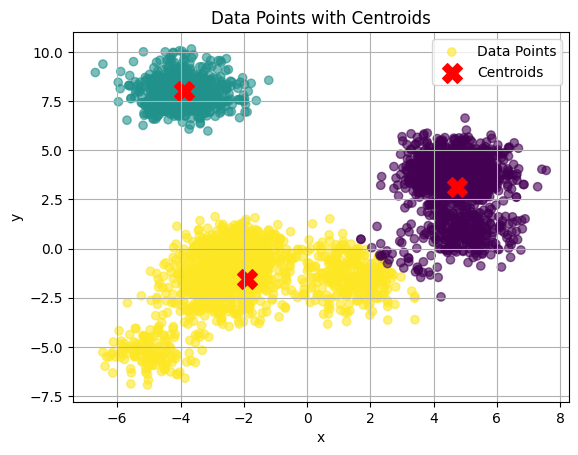

In [20]:
plt.scatter(p1_data[:, 0], p1_data[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Data Points')

plt.scatter(k[:, 0], k[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title("Data Points with Centroids")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
def calc_silhouette(X, labels, centroids):
    N = X.shape[0]
    K = centroids.shape[0]
    silhouettes = []

    for i in range(N):
        xi = X[i]
        ci = labels[i]
        
        same_cluster = X[labels == ci]
        if len(same_cluster) > 1:
            a = np.mean([np.linalg.norm(xi - p) for p in same_cluster if not np.array_equal(p, xi)])
        else:
            a = 0  

        b = np.inf
        for k in range(K):
            if k == ci:
                continue
            other_cluster = X[labels == k]
            if len(other_cluster) > 0:
                dist = np.mean([np.linalg.norm(xi - p) for p in other_cluster])
                b = min(b, dist)

        if max(a, b) == 0:
            silhouettes.append(0)
        else:
            silhouettes.append((b - a) / max(a, b))
    return np.mean(silhouettes)

In [23]:
s_scores =[]
for i in range(1,10):
    k, labels, _ = cluster_knn(p1_data, i)
    s = calc_silhouette(p1_data, labels, k)
    s_scores.append(s)

/var/folders/jw/6cygsm496qs9d6kbsmmwmnrc0000gn/T/ipykernel_81130/4106788016.py:28: RuntimeWarning: invalid value encountered in scalar divide
  silhouettes.append((b - a) / max(a, b))


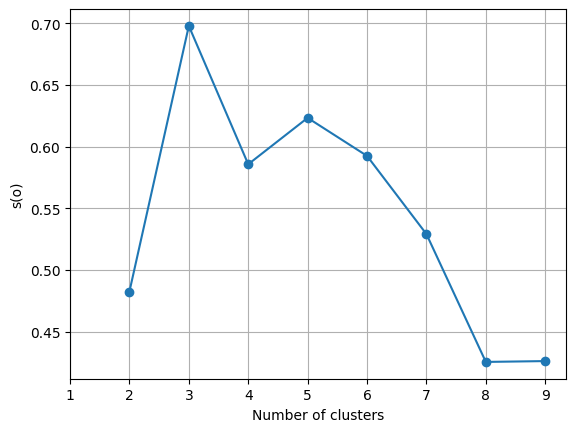

In [24]:
x_values = list(range(1, len(s_scores) + 1))

plt.plot(x_values, s_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("s(o)")
plt.xticks(x_values)
plt.grid(True)
plt.show()

## 2 Gaussian Mixture Models (GMMs)

### 2.2 Solving the optimization problem

In [25]:
p2_data = pd.read_pickle("./hw4_p2.pkl")
p2_data.shape

(2100, 2)

In [29]:
def draw_conf2D(mu, Sigma, ax, n_std=2, **kwargs):
    K = mu.shape[0]
    if K == 2:
        edgecolor = ['b','r']
    elif K == 3:
        edgecolor = ['g','b','r']
    else:
        edgecolor = ['k' for _ in range(K)]
    for i in range(mu.shape[0]):
        pearson = Sigma[i,0,1]/np.sqrt(Sigma[i,0,0]*Sigma[i,1,1] + 1e-12)
        ell_radius_x = np.sqrt(max(1 + pearson, 1e-12))
        ell_radius_y = np.sqrt(max(1 - pearson, 1e-12))
        ellipse = Ellipse((0, 0), width=ell_radius_x*2, height=ell_radius_y*2,
                          edgecolor=edgecolor[i], fill=False, **kwargs)

        scale_x = np.sqrt(max(Sigma[i,0,0], 1e-12)) * n_std
        mean_x  = mu[i,0]
        scale_y = np.sqrt(max(Sigma[i,1,1], 1e-12)) * n_std
        mean_y  = mu[i,1]

        transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        ax.add_patch(ellipse)
    return

In [34]:
def init_gmm(X, K, seed=0):
    rng = np.random.default_rng(seed)
    N, D = X.shape  
    mu = X[rng.choice(N, size=K, replace=False)].copy()
    cov = np.stack([np.cov(X.T) + 1e-3 * np.eye(D) for _ in range(K)], axis=0)
    alpha = np.ones(K) / K
    return mu, cov, alpha

In [38]:
def gaussian_logpdf(x, mu, Sigma):
    K, D = mu.shape[0], mu.shape[1]
    out = np.empty((x.shape[0], K))
    for k in range(K):
        Sk = Sigma[k]
        sign, logdet = np.linalg.slogdet(Sk)
        # if sign <= 0:  
        #     Sk = Sk + 1e-6*np.eye(D)
        #     sign, logdet = np.linalg.slogdet(Sk)
        diff = x - mu[k]
        sol = np.linalg.solve(Sk, diff.T)                 
        quad = np.sum(diff.T * sol, axis=0)              
        out[:, k] = -0.5 * (D*np.log(2*np.pi) + logdet + quad)
    return out

def e_step(X, mu, Sigma, alpha):
    log_pxk = gaussian_logpdf(X, mu, Sigma) + np.log(alpha + 1e-12)
    m = log_pxk.max(axis=1, keepdims=True)
    log_sum = m + np.log(np.sum(np.exp(log_pxk - m), axis=1, keepdims=True))
    gamma = np.exp(log_pxk - log_sum)
    return gamma  

def m_step(X, gamma):
    N_k = gamma.sum(axis=0)      
    alpha = (N_k / gamma.shape[0]).clip(min=1e-12)
    mu = (gamma.T @ X) / N_k[:, None]  
    K, D = mu.shape
    Sigma = np.zeros((K, D, D))
    for k in range(K):
        diff = X - mu[k]
        Sigma[k] = (diff.T * gamma[:, k]) @ diff / N_k[k]
        Sigma[k] += 1e-6 * np.eye(D)
    return mu, Sigma, alpha

def log_likelihood(X, mu, Sigma, alpha):
    log_pxk = gaussian_logpdf(X, mu, Sigma) + np.log(alpha + 1e-12)
    m = log_pxk.max(axis=1, keepdims=True)
    ll = np.sum(m + np.log(np.sum(np.exp(log_pxk - m), axis=1, keepdims=True)))
    return float(ll)

def em_gmm(X, K=3, max_iters=50, tol=1e-4, seed=0, plot_each_iter=True):
    mu, Sigma, alpha = init_gmm(X, K, seed=seed)
    lls = []
    figs = [] 

    for it in range(1, max_iters+1):
        gamma = e_step(X, mu, Sigma, alpha)
        mu_new, Sigma_new, alpha_new = m_step(X, gamma)
        ll = log_likelihood(X, mu_new, Sigma_new, alpha_new)
        lls.append(ll)

        if plot_each_iter:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.scatter(X[:,0], X[:,1], s=10, alpha=0.5)
            draw_conf2D(mu_new, Sigma_new, ax, n_std=2, linewidth=2)
            ax.set_title(f"GMM, K={K} — Iter {it}, LL={ll:.2f}")
            ax.set_xlabel("x1"); ax.set_ylabel("x2")
            ax.grid(True)
            plt.tight_layout()
            plt.show()
            figs.append(fig)

        mean_shift = np.max(np.linalg.norm(mu_new - mu, axis=1))
        if it > 1 and abs(ll - lls[-2]) < tol and mean_shift < np.sqrt(tol):
            mu, Sigma, alpha = mu_new, Sigma_new, alpha_new
            break
        mu, Sigma, alpha = mu_new, Sigma_new, alpha_new
    return mu, Sigma, alpha, np.array(lls)

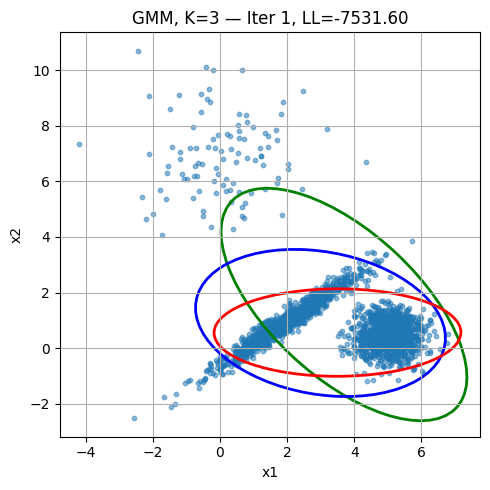

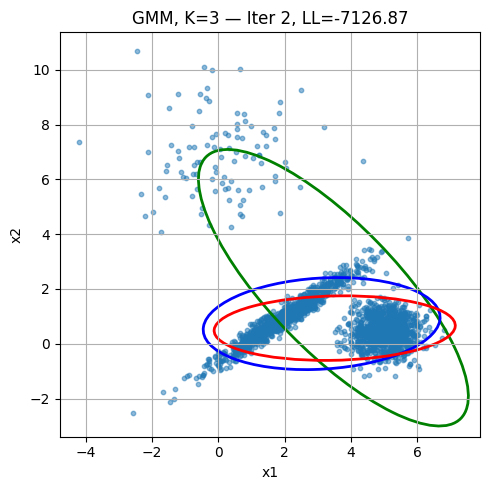

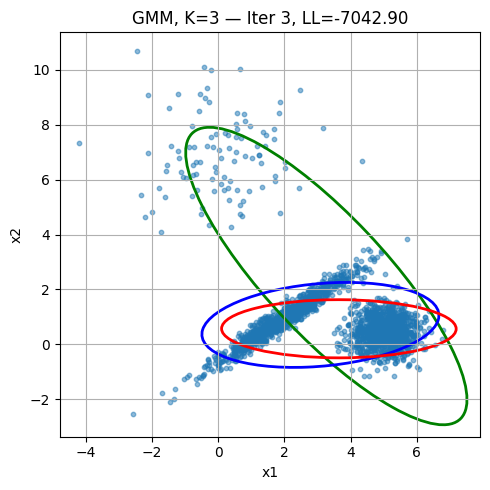

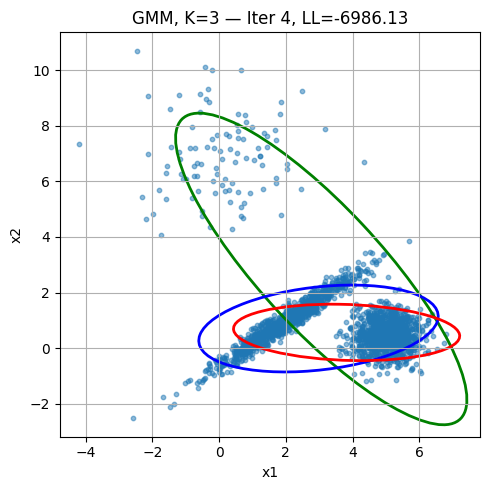

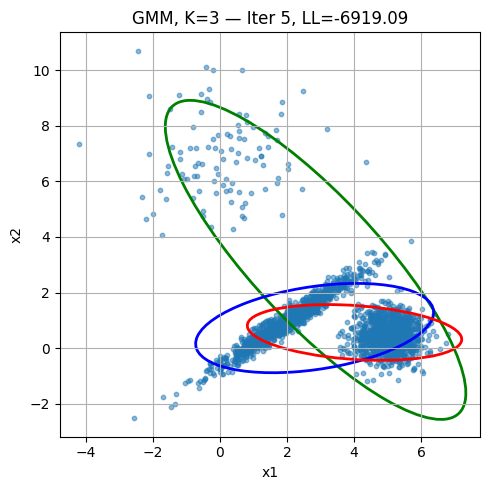

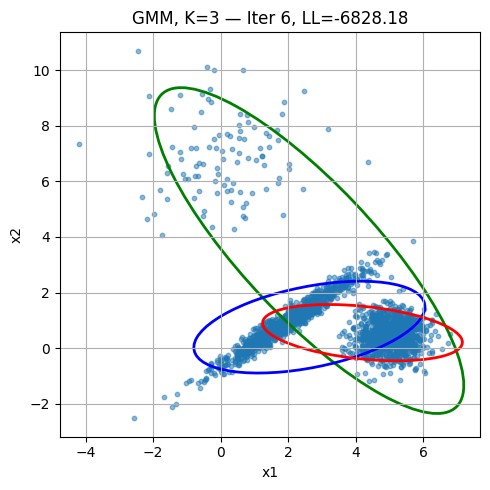

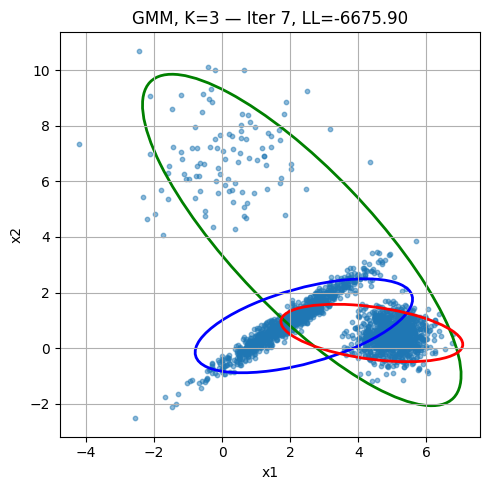

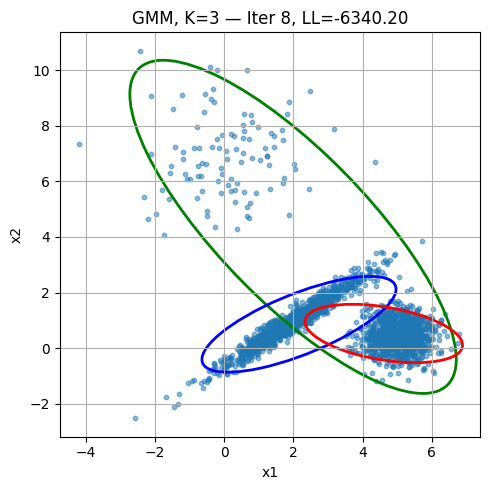

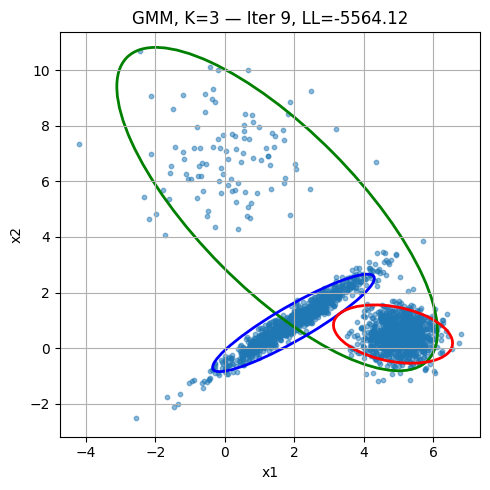

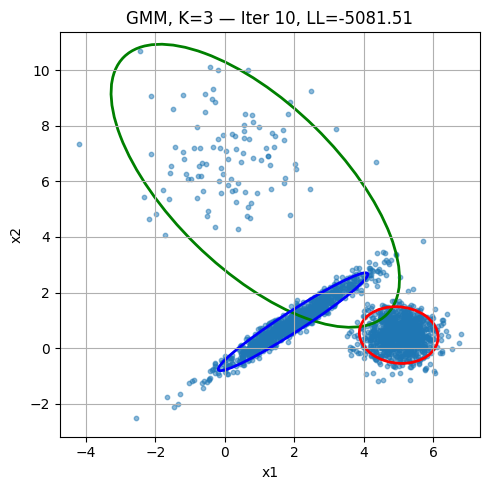

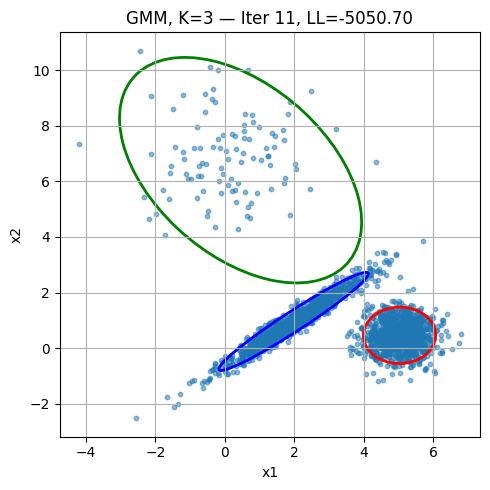

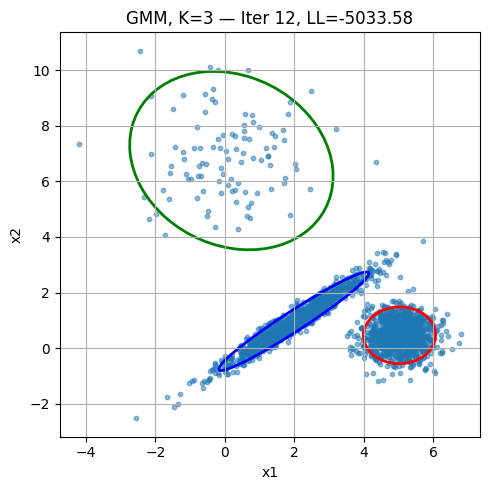

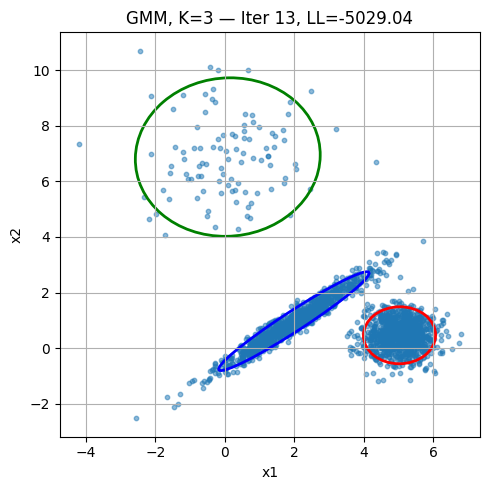

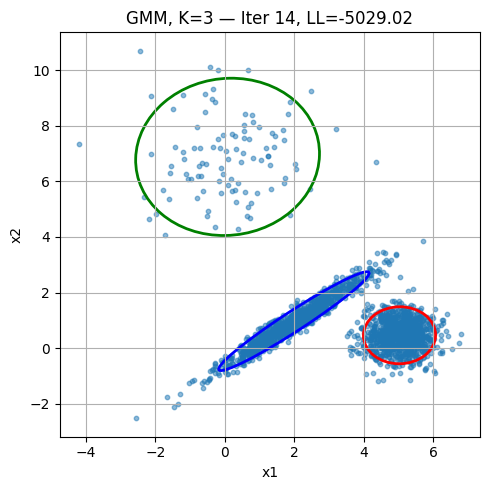

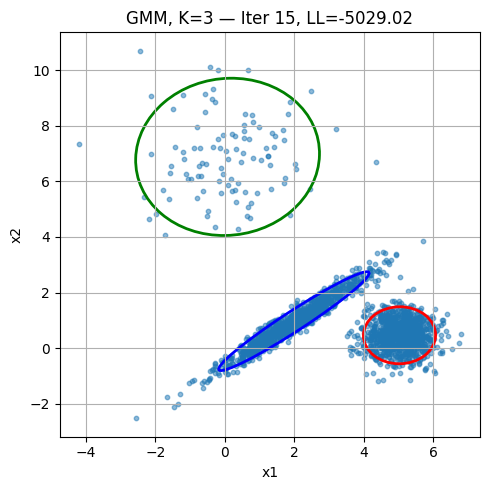

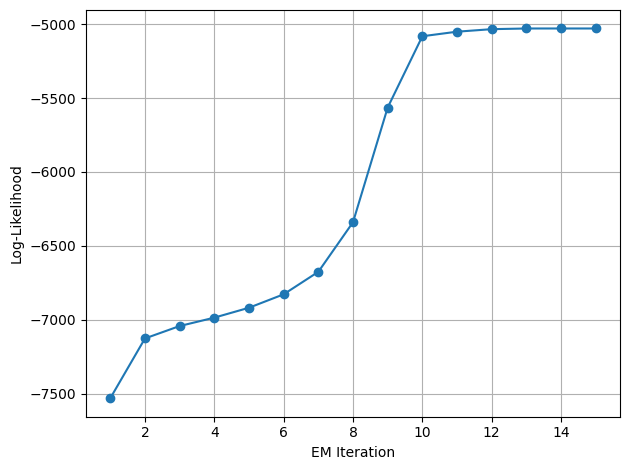

In [41]:
K = 3
mu, Sigma, alpha, lls = em_gmm(p2_data, K=K, max_iters=50, tol=1e-4, seed=7, plot_each_iter=True)

x_vals = np.arange(1, len(lls)+1)
plt.plot(x_vals, lls, marker='o')
plt.xlabel("EM Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()

K=1: final log-likelihood = -8083.98
K=2: final log-likelihood = -7020.47
K=3: final log-likelihood = -5029.02
K=4: final log-likelihood = -5025.82
K=5: final log-likelihood = -5024.24
K=6: final log-likelihood = -5023.32
K=7: final log-likelihood = -5020.56
K=8: final log-likelihood = -5018.60
K=9: final log-likelihood = -5021.33


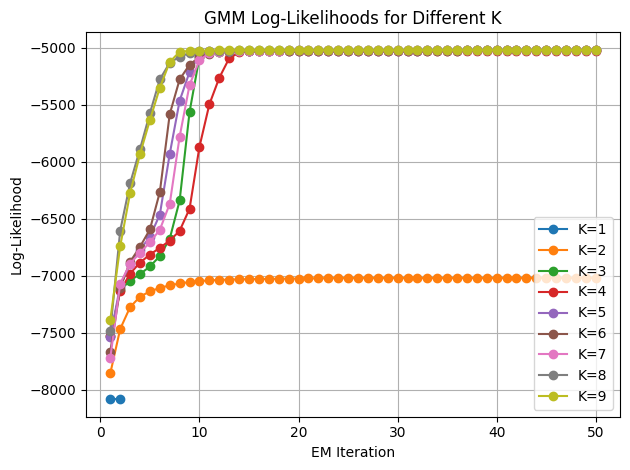

In [47]:
for K in range(1, 10):
    mu, Sigma, alpha, lls = em_gmm(
        p2_data, K=K, max_iters=50, tol=1e-4, seed=7, plot_each_iter=False
    )
    final_ll = lls[-1]
    print(f"K={K}: final log-likelihood = {final_ll:.2f}")

    plt.plot(np.arange(1, len(lls) + 1), lls, marker='o', label=f"K={K}")


plt.xlabel("EM Iteration")
plt.ylabel("Log-Likelihood")
plt.title("GMM Log-Likelihoods for Different K")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
